In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
from PIL import Image
import cv2

#get data in parallel
from multiprocessing import Pool

#plot (for image verification)
import matplotlib.cm as cm
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches

#access pdf data
from PyPDF2 import PdfFileWriter, PdfFileReader
from pdf2image import convert_from_path

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
path_data = os.path.join(ROOT_DIR,'datasets')

In [3]:
PACKAGE_PARENT = '../../..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

from UTILS.utils import frompng2images, from_path_scannpdf_book_2image, remove_embedded_bbox

/home/camille/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
#contours approximation: https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html

In [5]:
#The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of 
#possible values from 0 to 255. Typically zero is taken to be black, and 255 is taken to be white. Values in between 
#make up the different shades of gray.

# Extract image from scann pdf book

In [6]:
li_book_title = [path.split('/')[-1] for path in glob.glob(os.path.join(path_data, 
                                                                    'image_book/scan','*')) if path.endswith('pdf')]
li_book_title

['2004 The Venomous Reptiles of the Western Hemisphere I.pdf',
 '2004 The Venomous Reptiles of the Western Hemisphere II_OCR.pdf',
 '2008 Snakes of India.pdf',
 'Egan 2007 Snakes of Arabia.pdf']

In [13]:
#choose one unique book
book_title = '2008 Snakes of India.pdf'

In [ ]:
start_time = time.time()
print('Start taking image from book %s'%book_title)
from_path_scannpdf_book_2image(path=os.path.join(path_data, 'image_book/scan',book_title),
                               path_save=os.path.join(path_data, 'image_book/extracted_image/'+book_title.split('.')[0]))

#TODO: memory issue
for book_title in li_book_title:
    start_time = time.time()
    print('Start taking image from book %s'%book_title)
    from_path_scannpdf_book_2image(path=os.path.join(path_data, 'image_book/scan',book_title),
                                   path_save=os.path.join(path_data, 'image_book/extracted_image/'+book_title.split('.')[0]))
    print("--- %s minutes ---" % int(round(time.time() - start_time, 2)/60))

In [ ]:
#TODO: try parallel processing
    #li = [(pages[i], path_save, i, plot_) for i in range(len(pages))]
    #with Pool(nbrp) as p:
    #    p.map(frompng2images, li)

# Detailed example

### download a one page scann pdf 

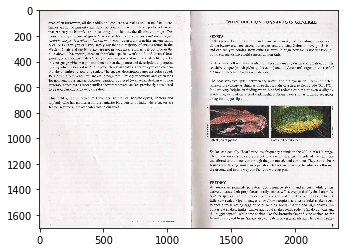

In [46]:
#to debug (if in the image you see an unwanted behavior, take the first number of the title and use it to access the
#correct page number to check here and debug)
#pages = convert_from_path(os.path.join(path_data, 'image_book/scan',book_title))
#im = pages[90] #,124, 110#TODO: add condition,s or intelligence
im = pages[7]
im = np.asarray(im)
plt.imshow(im);

#or simply to test on an image
im = cv2.imread(os.path.join(path_data, 'image_book/scan/one_scan_image.png'))

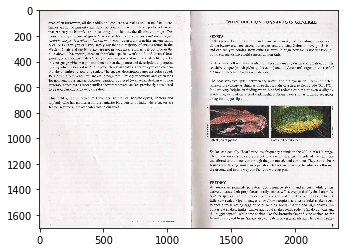

In [47]:
#keep a copy of the original file
imCopy = im.copy()
plt.imshow(imCopy);

### detect contour

In [48]:
#convert to grayscale
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

5133

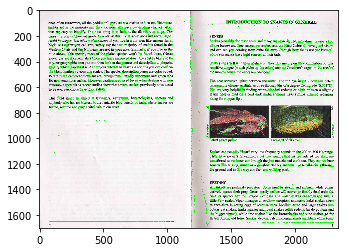

In [49]:
#For better accuracy we use binary images. So before finding contours, apply threshold: 
#if pixel is above 200 (first value, reducing to 160 may lead to to much images) we assign 255 (second value), 
#below we assign 0 (third value).
#0: black, 255: white
ret,thresh = cv2.threshold(imgray,200,255,0)
image, contours, hierarchy =  cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img_test  = cv2.drawContours(imCopy,contours,-1,(0,255,0))
plt.imshow(img_test);
len(contours)

### contour approximation to boundingbox

In [50]:
#create a list of rectangle which may correspond to an image
li_bbox = []
for contour in contours:
    poly = cv2.approxPolyDP(contour, 0.01 * cv2.arcLength(contour, False), False)
    x, y, w, h = cv2.boundingRect(poly)
    #remove if its really small compared to initial (i.e. smaller than 10%) image or equal to the initial image (or half the page
    #in case the book was scanned two pages at a time (horizontally or vertically))
    hi, wi, ci = imCopy.shape
    #avoid: not to smalle image (bad quality or can even be logo etc)
    #avoid: equal to the hole page
    #avoid: equal to half page when scanned with two page on the width
    #avoid: equal to half page when scanned with two page on the height
    if (h>(hi*0.1)) & (w>(wi*0.1)) & \
    ((h<(hi*0.95))|(w<(wi*0.95))) & \
    ((h<(hi*0.95))|(w>(wi*0.55))|((wi*0.45)>w)) & \
    ((w<(wi*0.95))|(h>(hi*0.55))|((hi*0.45)>h)):
        li_bbox.append((x,y,w,h))
len(li_bbox) 

2

(1808, 744, 466, 255)


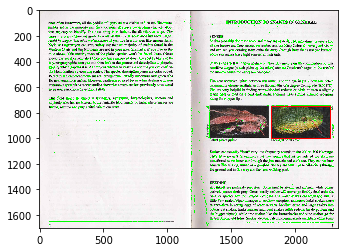

(1327, 744, 466, 254)


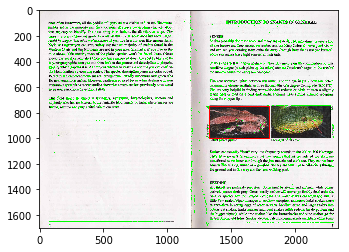

1700 2338


In [51]:
for bbox in li_bbox:
    x,y,w,h = bbox
    print(bbox)
    # Create figure and axes
    fig,ax = plt.subplots(1)
    # Display the image
    ax.imshow(imCopy)
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()
print(hi,wi)

### extract image from bbox

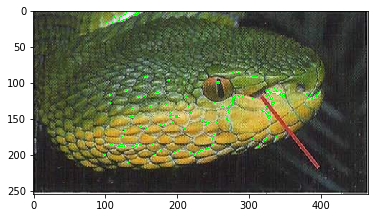

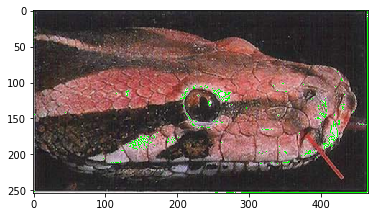

In [52]:
for bbox in li_bbox:
    x,y,w,h = bbox
    plt.imshow(imCopy[y:y+h,x:x+w])
    plt.show()

### small test for embeded image

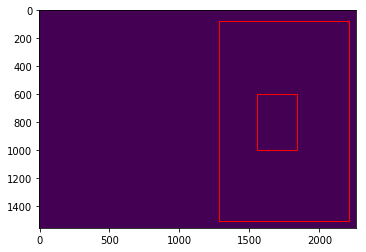

[(1281, 79, 933, 1425)]

In [53]:
#small test for embeded images
li_bbox = [(1281, 79, 933, 1425), (1557, 600, 282, 396)]
remove_embedded_bbox(li_bbox,plot_bbox=1)
#x1, y1, w1, h1